In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import re
from astropy.coordinates import Distance
from astropy import units as u
import matplotlib.pylab as plt
import matplotlib
import random

matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.2
matplotlib.rcParams["xtick.major.size"] = 8.0
matplotlib.rcParams["ytick.major.size"] = 8.0
matplotlib.rcParams["xtick.minor.size"] = 3.0
matplotlib.rcParams["ytick.minor.size"] = 3.0
matplotlib.rcParams["xtick.minor.visible"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.minor.visible"] = True
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams['hatch.linewidth'] = 1.5

Reading in data. The Foundation is separate from the normal Foundation dataset becaus these values were calculated concurrently with the Siebert data

In [2]:
massvel_werr = pd.read_csv('data/mass_vel_data_expanded.dat')

siebert20 = pd.read_csv('data/siebert20_HRvel.dat', delim_whitespace=True)
siebert20.vel = (siebert20.vel + 0.285*4.0)/(1 - 0.0322*4.0)
siebert20.vel_err = np.sqrt(siebert20.vel_err**2. + 0.22**2.)

In [3]:
found = pd.read_csv('data/salt2mu_kyle_foundsn.fitres', comment='#', delim_whitespace=True)
found.rename(columns={'CID':'Name'},inplace=True)
found.Name = found.Name.str.lower()

Combining the cosmological values with the velocity information

In [4]:
vel_local = []
velerr_local = []
mures_found = []
muerr_found = []
names = []
names_full = []

for i in found.index:
    name_snana = found.loc[i,'Name'].lower()
    for j in massvel_werr[massvel_werr.subsample == 'Foundation'].index:
        name_mass = massvel_werr[massvel_werr.subsample == 'Foundation'].loc[j,'Name']
        if name_mass == name_snana:
            vel_local.append(massvel_werr[massvel_werr.subsample == 'Foundation'].loc[j,'vel'])
            velerr_local.append(massvel_werr[massvel_werr.subsample == 'Foundation'].loc[j,'velerr'])
            mures_found.append(found.loc[i,'MURES'])
            muerr_found.append(found.loc[i,'MUERR'])
            names_full.append(name_mass)
            if (massvel_werr.loc[j,'vel'] < -13) or (name_mass == 'asassn16fo'):
                names.append(name_mass)
            else:
                names.append('')
vel_local = np.array(vel_local)
velerr_local = np.array(velerr_local)
mures_found = np.array(mures_found)
muerr_found = np.array(muerr_found)
names = np.array(names)
names_full = np.array(names_full)

Making cuts based on velocity and creating masks based on the hubble residual for use later

In [5]:
vel_local_n = vel_local[(vel_local < -8)]
velerr_local = velerr_local[(vel_local < -8)]
mures_found = mures_found[(vel_local < -8)]
muerr_found = muerr_found[(vel_local < -8)]
names = names[(vel_local < -8)]
names_full = names_full[(vel_local < -8)]

weights_vel = 1.0/(np.array(velerr_local)**2.0)
weights_mu = 1.0/(np.array(muerr_found)**2.0)

pos_mask = np.array(mures_found-np.mean(mures_found) > 0.0)
neg_mask = np.array(mures_found-np.mean(mures_found) < 0.0)

pos_mask_old = np.array(mures_found-np.mean(mures_found) > 0.0)
neg_mask_old = np.array(mures_found-np.mean(mures_found) < 0.0)

vel_pos = np.average(np.array(vel_local_n)[pos_mask],
                     weights=weights_vel[pos_mask])
vel_err_pos = 1.0/np.sqrt(np.sum(weights_vel[pos_mask]))
mures_pos = np.average(mures_found[pos_mask]-np.mean(mures_found),
                       weights=weights_mu[pos_mask])
muerr_pos = 1.0/np.sqrt(np.sum(weights_mu[pos_mask]))

vel_neg = np.average(np.array(vel_local_n)[neg_mask],
                      weights=weights_vel[neg_mask])
vel_err_neg = 1.0/np.sqrt(np.sum(weights_vel[neg_mask]))
mures_neg = np.average(mures_found[neg_mask]-np.mean(mures_found),
                        weights=weights_mu[neg_mask])
muerr_neg = 1.0/np.sqrt(np.sum(weights_mu[neg_mask]))

Plotting helper functions

In [6]:
def muresVelPlot(data, label, markercolor, violincolor, hist_color_high, hist_color_low):
    fig, ax = plt.subplots(2,2,figsize=(18,12),gridspec_kw={'width_ratios':[2,1],'height_ratios':[1,2]})
    plt.subplots_adjust(hspace=0.0,wspace=0.0)
    fig.delaxes(ax[0,1])
    
    ax[0,0].set_xticklabels([])
    ax[0,0].set_yticklabels([])
    ax[1,1].set_xticklabels([])
    ax[1,1].set_yticklabels([])
    ax[0,0].set_xticks([])
    ax[0,0].set_yticks([])
    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])
    
    ax[1,0].plot(data.mures-np.median(data.mures), data.vel, marker='o', color=markercolor)
    ax[1,0].errorbar(data.mures-np.median(data.mures),
                     xerr=data.muerr,
                     yerr=data.velerr, marker='o', color=markercolor)
    
def make_bootstraps(data):
    data_copy = data.copy(deep=True)
    data_copy['mures'] = np.random.normal(loc=data_copy['mures'], scale=data_copy['muerr'])
    data_copy['vel'] = np.random.normal(loc=data_copy['vel'], scale=data_copy['velerr'])
    return data_copy
def getAvgErr(vals, errs):
    weights = 1./(errs**2.)
    avg = np.average(vals, weights=weights)
    err_stat = 1./np.sqrt(np.sum(weights))
    return avg, err_stat
def getAvgPosNeg(data_arr):
    comb = pd.concat(data_arr)
    weights_vel = 1.0/(np.array(comb['velerr'])**2.0)
    weights_mu = 1.0/(np.array(comb['muerr'])**2.0)

    pos_mask = np.array(comb['mures'] > 0.0)
    neg_mask = np.array(comb['mures'] < 0.0)
    
    vel_pos = np.average(np.array(comb['vel'])[pos_mask],weights=weights_vel[pos_mask])
    vel_err_pos = 1.0/np.sqrt(np.sum(weights_vel[pos_mask]))
    mures_pos = np.average(np.array(comb['mures'])[pos_mask],weights=weights_mu[pos_mask])
    muerr_pos = 1.0/np.sqrt(np.sum(weights_mu[pos_mask]))
    vel_neg = np.average(np.array(comb['vel'])[neg_mask],weights=weights_vel[neg_mask])
    vel_err_neg = 1.0/np.sqrt(np.sum(weights_vel[neg_mask]))
    mures_neg = np.average(np.array(comb['mures'])[neg_mask],weights=weights_mu[neg_mask])
    muerr_neg = 1.0/np.sqrt(np.sum(weights_mu[neg_mask]))
    
    return mures_pos,mures_neg,vel_pos,vel_neg
def getAvgHiLow(data_arr, vel_split=-11.0):
    comb = pd.concat(data_arr)
    weights_vel = 1.0/(np.array(comb['velerr'])**2.0)
    weights_mu = 1.0/(np.array(comb['muerr'])**2.0)

    hi_mask = np.array(comb['vel'] < vel_split)
    low_mask = np.array(comb['vel'] > vel_split)
    
    vel_hi = np.average(np.array(comb['vel'])[hi_mask],weights=weights_vel[hi_mask])
    vel_err_hi = 1.0/np.sqrt(np.sum(weights_vel[hi_mask]))
    mures_hi = np.average(np.array(comb['mures'])[hi_mask],weights=weights_mu[hi_mask])
    muerr_hi = 1.0/np.sqrt(np.sum(weights_mu[hi_mask]))
    vel_low = np.average(np.array(comb['vel'])[low_mask],weights=weights_vel[low_mask])
    vel_err_low = 1.0/np.sqrt(np.sum(weights_vel[low_mask]))
    mures_low = np.average(np.array(comb['mures'])[low_mask],weights=weights_mu[low_mask])
    muerr_low = 1.0/np.sqrt(np.sum(weights_mu[low_mask]))
    
    return mures_hi,mures_low,vel_hi,vel_low
def make_bootstraps(data):
    data_copy = data.copy(deep=True)
    data_copy['mures'] = np.random.normal(loc=data_copy['mures'], scale=data_copy['muerr'])
    data_copy['vel'] = np.random.normal(loc=data_copy['vel'], scale=data_copy['velerr'])
    
    weighted_hr = np.sum((data_copy['mures']/data_copy['muerr']**2.0))/np.sum((data_copy['mures']**-2.0))

    return data_copy
def getAvgHiLow_test(data_arr, vel_split=-11.0, ret='numpy'):
    comb = pd.concat(data_arr)
    weights_vel = 1.0/(np.array(comb['velerr'])**2.0)
    weights_mu = 1.0/(np.array(comb['muerr'])**2.0)
    
    weighted_hr = np.sum((comb['mures']/comb['muerr']**2.0))/np.sum((comb['muerr']**-2.0))

    weighted_avg_hr = np.average(np.array(comb['mures']),weights=weights_mu)


    hi_mask = np.array(comb['vel'] < vel_split)
    low_mask = np.array(comb['vel'] > vel_split)
    
    weighted_hr_hi = np.sum((comb['mures'][hi_mask]/comb['muerr'][hi_mask]**2.0))/np.sum((comb['muerr'][hi_mask]**-2.0))

    weighted_hr_low = np.sum((comb['mures'][low_mask]/comb['muerr'][low_mask]**2.0))/np.sum((comb['muerr'][low_mask]**-2.0))

    weighted_vel_hi = np.sum((comb['vel'][hi_mask]/comb['velerr'][hi_mask]**2.0))/np.sum((comb['velerr'][hi_mask]**-2.0))
    weighted_vel_low = np.sum((comb['vel'][low_mask]/comb['velerr'][low_mask]**2.0))/np.sum((comb['velerr'][low_mask]**-2.0))
    
    vel_hi = np.average(np.array(comb['vel'])[hi_mask],weights=weights_vel[hi_mask])
    vel_err_hi = 1.0/np.sqrt(np.sum(weights_vel[hi_mask]))
    mures_hi = np.average(np.array(comb['mures'])[hi_mask],weights=weights_mu[hi_mask])
    muerr_hi = 1.0/np.sqrt(np.sum(weights_mu[hi_mask]))
    vel_low = np.average(np.array(comb['vel'])[low_mask],weights=weights_vel[low_mask])
    vel_err_low = 1.0/np.sqrt(np.sum(weights_vel[low_mask]))
    mures_low = np.average(np.array(comb['mures'])[low_mask],weights=weights_mu[low_mask])
    muerr_low = 1.0/np.sqrt(np.sum(weights_mu[low_mask]))
    
    if ret=='numpy':
        return mures_hi,mures_low,vel_hi,vel_low
    elif ret=='custom':
        return weighted_hr_hi,weighted_hr_low,weighted_vel_hi,weighted_vel_low

In [7]:
found_snana = pd.DataFrame({'mures':mures_found-np.median(mures_found),
                            'muerr':muerr_found,'vel':vel_local_n,'velerr':velerr_local})
siebert20['muerr'] = siebert20['mures_err'].copy()
siebert20['velerr'] = siebert20['vel_err'].copy()

Creating new datsets which have been shifted to have a weighted mean of $0$

In [8]:
found_snana_m = found_snana.copy(deep=True)

weighted_avg_found = np.sum((found_snana['mures']/found_snana['muerr']**2.0))/np.sum((found_snana['muerr']**-2.0))
print('Weighted Avg Found (orig): {}'.format(weighted_avg_found))

found_snana_m['mures'] = found_snana_m['mures'] - weighted_avg_found
weighted_avg_found_m = np.sum((found_snana_m['mures']/found_snana_m['muerr']**2.0))/np.sum((found_snana_m['muerr']**-2.0))
print('Weighted Avg Found (mod): {}'.format(weighted_avg_found_m))

Weighted Avg Found (orig): -0.00308235684838
Weighted Avg Found (mod): -4.12657066239e-18


In [9]:
siebert20_m = siebert20.copy(deep=True)
weighted_avg_siebert = np.sum((siebert20_m['mures']/siebert20_m['muerr']**2.0))/np.sum((siebert20_m['muerr']**-2.0))
print('Weighted Avg Siebert (orig): {}'.format(weighted_avg_siebert))

siebert20_m['mures'] = siebert20_m['mures'] - weighted_avg_siebert
weighted_avg_siebert_m = np.sum((siebert20_m['mures']/siebert20_m['muerr']**2.0))/np.sum((siebert20_m['muerr']**-2.0))
print('Weighted Avg Siebert (mod): {}'.format(weighted_avg_siebert_m))

Weighted Avg Siebert (orig): 0.0162539367329
Weighted Avg Siebert (mod): -5.45042906435e-18


Plotting Foundation and S20 data in the style of S20 Fig. 7. The data from S20 have different velocities than published as they have been phased to maximum light. Because of this, the range of medians for each subset via bootstrapping are done here and may be different than published, but they are consistent with the results of S20.

Neg HR vel_found = -11.089+/-0.185
Pos HR vel_found = -10.881+/-0.186


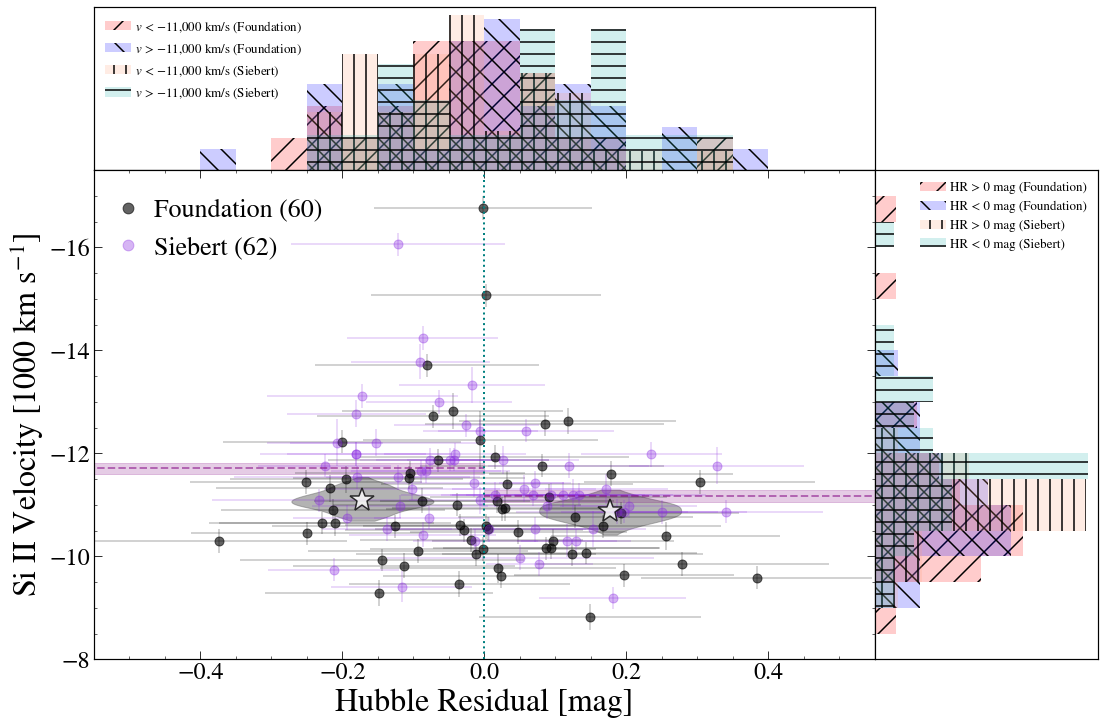

In [14]:
fig, ax = plt.subplots(2,2,figsize=(18,12), gridspec_kw={'width_ratios':[3.5,1],'height_ratios':[1,3]})
plt.subplots_adjust(hspace=0.0,wspace=0.0)
fig.delaxes(ax[0,1])

ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

plotalpha = 0.35
ms = 9

found_color = 'black'
ax[1,0].plot(mures_found-np.median(mures_found), vel_local_n,
             'o',label='Foundation ({:d})'.format(len(mures_found)),
             color=found_color,alpha=plotalpha*1.75,markersize=ms)
ax[1,0].errorbar(mures_found-np.median(mures_found), vel_local_n, 
             xerr=muerr_found, yerr=velerr_local,linestyle='',
                 markersize=20,capsize=0,color=found_color,alpha=plotalpha/2.0,label=None)

siebert_color = 'blueviolet'
ax[1,0].plot(siebert20_m.mures, siebert20_m.vel,'o', color=siebert_color,alpha=plotalpha,
             label='Siebert ({:d})'.format(len(siebert20_m.mures)),markersize=ms)
ax[1,0].errorbar(siebert20_m.mures, siebert20_m.vel,
            xerr=siebert20_m.mures_err,yerr=siebert20_m.vel_err,
            linestyle='',markersize=20,capsize=0,color=siebert_color,alpha=plotalpha/2.0,label=None)

ax[1,0].set_xlim(-0.55,0.55)
ax[1,0].set_ylim(-8,-17.5)

histalpha=0.2

mubins = np.linspace(-0.6,0.6,25)
ax[0,0].hist(mures_found[vel_local_n < -11]-np.median(mures_found),hatch='/',
             bins=mubins,density=True,color='red',alpha=histalpha,label=r'$v$ < $-$11,000 km/s (Foundation)')
ax[0,0].hist(mures_found[vel_local_n > -11]-np.median(mures_found),hatch='\\',
             bins=mubins,density=True,color='blue',alpha=histalpha,label=r'$v$ > $-$11,000 km/s (Foundation)')
ax[0,0].hist(siebert20_m.mures[siebert20_m.vel < -11],bins=mubins,hatch='|',
             density=True,color='lightsalmon',alpha=histalpha,label=r'$v$ < $-$11,000 km/s (Siebert)')
ax[0,0].hist(siebert20_m.mures[siebert20_m.vel > -11],bins=mubins,hatch='-',
             density=True,color='lightseagreen',alpha=histalpha,label=r'$v$ > $-$11,000 km/s (Siebert)')
ax[0,0].legend(fontsize=13,frameon=False, handletextpad=0.3,loc='upper left')


velbins = np.linspace(-19,-7,25)
ax[1,1].hist(np.array(vel_local_n)[pos_mask_old],bins=velbins,density=True,color='red',hatch='/',
             alpha=histalpha,orientation='horizontal',label='HR > 0 mag (Foundation)')
ax[1,1].hist(np.array(vel_local_n)[neg_mask_old],bins=velbins,density=True,color='blue',hatch='\\',
             alpha=histalpha,orientation='horizontal',label='HR < 0 mag (Foundation)')
ax[1,1].hist(np.array(siebert20_m.vel)[siebert20_m.mures > 0.0],bins=velbins,density=True,color='lightsalmon',hatch='|',
             alpha=histalpha,orientation='horizontal',label='HR > 0 mag (Siebert)')
ax[1,1].hist(np.array(siebert20_m.vel)[siebert20_m.mures < 0.0],bins=velbins,density=True,color='lightseagreen',hatch='-',
             alpha=histalpha,orientation='horizontal',label='HR < 0 mag (Siebert)')
ax[1,1].legend(fontsize=13,frameon=False, handletextpad=0.3)

ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[0,0].set_xlim(ax[1,0].get_xlim())

mures_pos_arr = []
vel_pos_arr = []
mures_neg_arr = []
vel_neg_arr = []

random.seed(1766)
for i in range(100):
    found_boot = make_bootstraps(found_snana_m)  
    whr_boot = np.sum((found_boot['mures']/found_boot['muerr']**2.0))/np.sum((found_boot['muerr']**-2.0))
    found_boot['mures'] = found_boot['mures'] - whr_boot
    mures_pos,mures_neg,vel_pos,vel_neg=getAvgPosNeg([found_boot])
    mures_pos_arr.append(mures_pos)
    vel_pos_arr.append(vel_pos)
    mures_neg_arr.append(mures_neg)
    vel_neg_arr.append(vel_neg)
    
mupos = np.mean(mures_pos_arr)
mupos_err = np.std(mures_pos_arr)
muneg = np.mean(mures_neg_arr)
muneg_err = np.std(mures_neg_arr)
velpos = np.mean(vel_pos_arr)
velpos_err = np.std(vel_pos_arr)
velneg = np.mean(vel_neg_arr)
velneg_err = np.std(vel_neg_arr)

print('Neg HR vel_found = {:.3f}+/-{:.3f}'.format(velneg,velneg_err))
print('Pos HR vel_found = {:.3f}+/-{:.3f}'.format(velpos,velpos_err))

vp = ax[1,0].violinplot([vel_pos_arr,vel_neg_arr],[mupos,muneg],
                        widths=0.2,showmeans=False,showextrema=False,
                        showmedians=False,bw_method='silverman')
for pc in vp['bodies']:
    pc.set_facecolor('dimgray')
    pc.set_edgecolor('dimgray')
    pc.set_alpha(0.5)
    
# Adding Siebert lines to plot
mures_pos_arr_s = []
vel_pos_arr_s = []
mures_neg_arr_s = []
vel_neg_arr_s = []
for i in range(100):
    siebert_boot = make_bootstraps(siebert20_m)    
    whr_boot = np.sum((siebert_boot['mures']/siebert_boot['muerr']**2.0))/np.sum((siebert_boot['muerr']**-2.0))
    siebert_boot['mures'] = siebert_boot['mures'] - whr_boot
    mures_pos_s,mures_neg_s,vel_pos_s,vel_neg_s=getAvgPosNeg([siebert_boot])
    mures_pos_arr_s.append(mures_pos_s)
    vel_pos_arr_s.append(vel_pos_s)
    mures_neg_arr_s.append(mures_neg_s)
    vel_neg_arr_s.append(vel_neg_s)
    
mupos_s = np.mean(mures_pos_arr_s)
mupos_err_s = np.std(mures_pos_arr_s)
muneg_s = np.mean(mures_neg_arr_s)
muneg_err_s = np.std(mures_neg_arr_s)
velpos_s = np.mean(vel_pos_arr_s)
velpos_err_s = np.std(vel_pos_arr_s)
velneg_s = np.mean(vel_neg_arr_s)
velneg_err_s = np.std(vel_neg_arr_s)

ax[1,0].plot([-0.65,0.0],[velneg_s,velneg_s],color='purple',linestyle='--',alpha=0.5)
ax[1,0].fill_between([-0.65,0.0],
                    [velneg_s+velneg_err_s,velneg_s+velneg_err_s],
                    [velneg_s-velneg_err_s,velneg_s-velneg_err_s],color='purple',alpha=0.2)
ax[1,0].plot([0.65,0.0],[velpos_s,velpos_s],color='purple',linestyle='--',alpha=0.5)
ax[1,0].fill_between([0.65,0.0],
                    [velpos_s+velpos_err_s,velpos_s+velpos_err_s],
                    [velpos_s-velpos_err_s,velpos_s-velpos_err_s],color='purple',alpha=0.2)
    
ax[1,0].plot([mupos,muneg],[velpos,velneg],
             marker='*',color='white',markeredgecolor='k',markeredgewidth=1.5,
             linestyle='',markersize=25, alpha=0.8)

ax[1,0].plot([0,0],[-8,-20],linestyle=':',color='teal')

ax[1,0].tick_params(labelsize=24)
ax[1,0].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
ax[1,0].legend(fontsize=26,loc='upper left',markerscale=1.2, frameon=False, handletextpad=0.0,bbox_to_anchor=(-0.02, 0.99))

# for i in range(len(mures_found)):
#     ax[1,0].text(mures_found[i]-np.median(mures_found)+0.01, vel_local_n[i]-0.1, names[i])
ax[1,0].set_xlabel('Hubble Residual [mag]',fontsize=32)
ax[1,0].set_ylabel(r'Si II Velocity [1000 km s$^{-1}$]',fontsize=32)

plt.savefig('muresVel_figures/found_muresvel_w_siebert_renorm.pdf',bbobx_inches='tight')
plt.savefig('muresVel_figures/found_muresvel_w_siebert_renorm.png',bbox_inches='tight',dpi=600,transparent=True)

Same as above, but in the style of S20 Fig. 8.

Weighted HR (Found) = -0.001
Weighted HR (Siebert) = -0.000
High-velocity HR = -0.006+/-0.047
Normal-velocity HR = 0.001+/-0.012
High-velocity HR (Siebert) = -0.060+/-0.025
Normal-velocity HR (Siebert) = 0.028+/-0.013


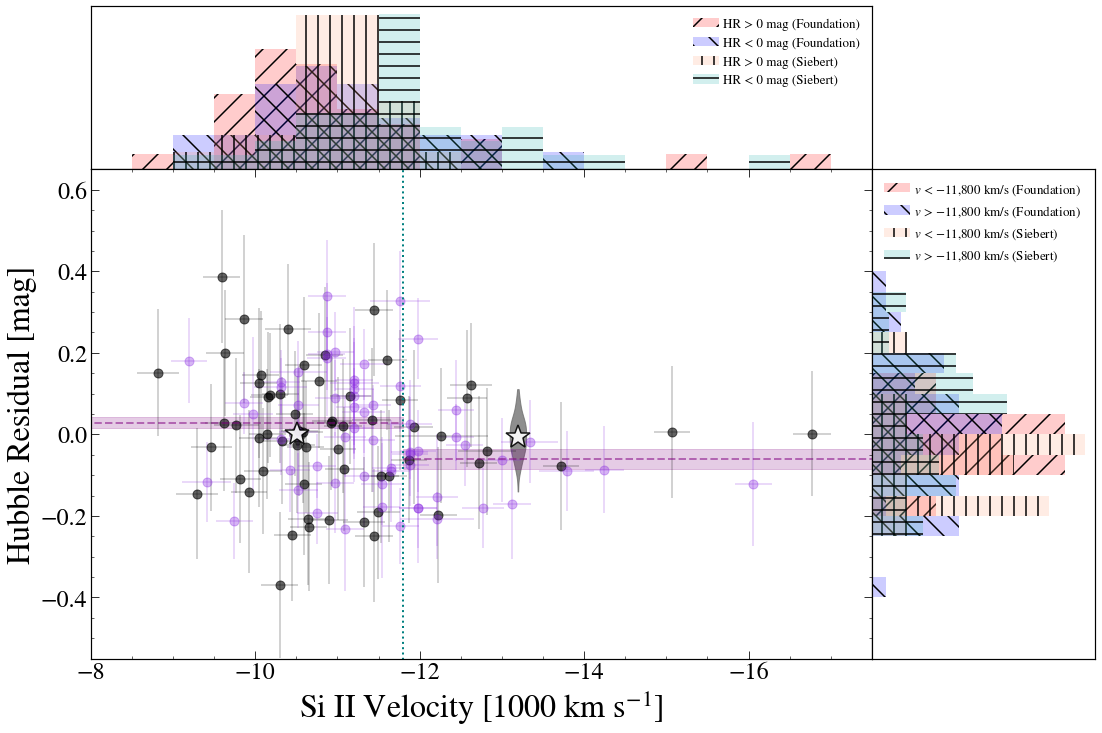

In [13]:
fig, ax = plt.subplots(2,2,figsize=(18,12), gridspec_kw={'width_ratios':[3.5,1],'height_ratios':[1,3]})
plt.subplots_adjust(hspace=0.0,wspace=0.0)
fig.delaxes(ax[0,1])

ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

plotalpha = 0.35
ms = 9

found_color = 'black'
ax[1,0].plot(found_snana_m['vel'], found_snana_m['mures'],
             'o',label='Foundation ({:d})'.format(len(found_snana_m)),
             color=found_color,alpha=plotalpha*1.75,markersize=ms)
ax[1,0].errorbar(found_snana_m['vel'], found_snana_m['mures'], 
                 yerr=found_snana_m['muerr'], xerr=found_snana_m['velerr'],linestyle='',
                 markersize=20,capsize=0,color=found_color,alpha=plotalpha/2.0,label=None)

siebert_color = 'blueviolet'
ax[1,0].plot(siebert20_m.vel,siebert20_m.mures,'o', color=siebert_color,alpha=plotalpha,
             label='Siebert ({:d})'.format(len(siebert20_m.mures)),markersize=ms)
ax[1,0].errorbar(siebert20_m.vel,siebert20_m.mures,
                 yerr=siebert20_m.mures_err,xerr=siebert20_m.vel_err,
                 linestyle='',markersize=20,capsize=0,color=siebert_color,alpha=plotalpha/2.0,label=None)

histalpha=0.2
mubins = np.linspace(-0.6,0.6,25)
velbins = np.linspace(-19,-7,25)

ax[1,1].hist(found_snana_m[vel_local_n < -11.8]['mures'],hatch='/',
             bins=mubins,density=True,color='red',alpha=histalpha,
             orientation='horizontal',label=r'$v$ < $-$11,800 km/s (Foundation)')
ax[1,1].hist(found_snana_m[vel_local_n > -11.8]['mures'],hatch='\\',
             bins=mubins,density=True,color='blue',alpha=histalpha,
             orientation='horizontal',label=r'$v$ > $-$11,800 km/s (Foundation)')
ax[1,1].hist(siebert20_m.mures[siebert20_m.vel < -11.8],bins=mubins,hatch='|',
             density=True,color='lightsalmon',alpha=histalpha,
             orientation='horizontal',label=r'$v$ < $-$11,800 km/s (Siebert)')
ax[1,1].hist(siebert20_m.mures[siebert20_m.vel > -11.8],bins=mubins,hatch='-',
             density=True,color='lightseagreen',alpha=histalpha,
             orientation='horizontal',label=r'$v$ > $-$11,800 km/s (Siebert)')
ax[1,1].legend(fontsize=13,frameon=False, handletextpad=0.3,loc='upper left')

ax[0,0].hist(found_snana_m[found_snana_m.mures > 0.0]['vel'],bins=velbins,density=True,color='red',hatch='/',
             alpha=histalpha,label='HR > 0 mag (Foundation)')
ax[0,0].hist(found_snana_m[found_snana_m.mures < 0.0]['vel'],bins=velbins,density=True,color='blue',hatch='\\',
             alpha=histalpha,label='HR < 0 mag (Foundation)')
ax[0,0].hist(np.array(siebert20_m.vel)[siebert20_m.mures > 0.0],bins=velbins,density=True,color='lightsalmon',hatch='|',
             alpha=histalpha,label='HR > 0 mag (Siebert)')
ax[0,0].hist(np.array(siebert20_m.vel)[siebert20_m.mures < 0.0],bins=velbins,density=True,color='lightseagreen',hatch='-',
             alpha=histalpha,label='HR < 0 mag (Siebert)')
ax[0,0].legend(fontsize=13,frameon=False, handletextpad=0.3)


mures_hi_arr = []
vel_hi_arr = []
mures_low_arr = []
vel_low_arr = []

random.seed(1766)
for i in range(100):
    found_boot = make_bootstraps(found_snana_m)
    whr_boot = np.sum((found_boot['mures']/found_boot['muerr']**2.0))/np.sum((found_boot['muerr']**-2.0))
    found_boot['mures'] = found_boot['mures'] - whr_boot
    mures_hi,mures_low,vel_hi,vel_low=getAvgHiLow_test([found_boot],vel_split=-11.8)
    mures_hi_arr.append(mures_hi)
    vel_hi_arr.append(vel_hi)
    mures_low_arr.append(mures_low)
    vel_low_arr.append(vel_low)
    
muhi = np.mean(mures_hi_arr)
muhi_err = np.std(mures_hi_arr)
mulow = np.mean(mures_low_arr)
mulow_err = np.std(mures_low_arr)
velhi = np.mean(vel_hi_arr)
velhi_err = np.std(vel_hi_arr)
vellow = np.mean(vel_low_arr)
vellow_err = np.std(vel_low_arr)

vp = ax[1,0].violinplot([mures_hi_arr,mures_low_arr],[velhi,vellow],
                        widths=0.2,showmeans=False,showextrema=False,
                        showmedians=False,bw_method='silverman')
for pc in vp['bodies']:
    pc.set_facecolor('dimgray')
    pc.set_edgecolor('dimgray')
    pc.set_alpha(0.75)
    
# Adding Siebert lines to plot
mures_hi_arr_s = []
vel_hi_arr_s = []
mures_low_arr_s = []
vel_low_arr_s = []
for i in range(100):
    siebert_boot = make_bootstraps(siebert20_m)    
    whr_boot = np.sum((siebert_boot['mures']/siebert_boot['muerr']**2.0))/np.sum((siebert_boot['muerr']**-2.0))
    siebert_boot['mures'] = siebert_boot['mures'] - whr_boot
    mures_hi_s,mures_low_s,vel_hi_s,vel_low_s=getAvgHiLow_test([siebert_boot],vel_split=-11.8)
    mures_hi_arr_s.append(mures_hi_s)
    vel_hi_arr_s.append(vel_hi_s)
    mures_low_arr_s.append(mures_low_s)
    vel_low_arr_s.append(vel_low_s)
    
muhi_s = np.mean(mures_hi_arr_s)
muhi_err_s = np.std(mures_hi_arr_s)
mulow_s = np.mean(mures_low_arr_s)
mulow_err_s = np.std(mures_low_arr_s)
velhi_s = np.mean(vel_hi_arr_s)
velhi_err_s = np.std(vel_hi_arr_s)
vellow_s = np.mean(vel_low_arr_s)
vellow_err_s = np.std(vel_low_arr_s)

weighted_hr_found = np.sum((mures_found/muerr_found**2.0))/np.sum((muerr_found**-2.0))
print('Weighted HR (Found) = {:.3f}'.format(weighted_hr_found))
weighted_hr_siebert = np.sum((siebert20_m.mures/siebert20_m.mures_err**2.0))/np.sum((siebert20_m.mures_err**-2.0))
print('Weighted HR (Siebert) = {:.3f}'.format(weighted_hr_siebert))

ax[1,0].plot([-6,-11.8],[mulow_s,mulow_s],color='purple',linestyle='--',alpha=0.5)
ax[1,0].fill_between([-6,-11.8],
                    [mulow_s+mulow_err_s,mulow_s+mulow_err_s],
                    [mulow_s-mulow_err_s,mulow_s-mulow_err_s],color='purple',alpha=0.2)
ax[1,0].plot([-11.8,-21],[muhi_s,muhi_s],color='purple',linestyle='--',alpha=0.5)
ax[1,0].fill_between([-11.8,-21],
                    [muhi_s+muhi_err_s,muhi_s+muhi_err_s],
                    [muhi_s-muhi_err_s,muhi_s-muhi_err_s],color='purple',alpha=0.2)
    
ax[1,0].plot([velhi,vellow],[muhi,mulow],
             marker='*',markerfacecolor='white',markeredgecolor='k',markeredgewidth=1.5,
             linestyle='',markersize=25, alpha=0.9)

ax[1,0].plot([-11.8,-11.8],[-1.5,1.5],linestyle=':',color='teal')
ax[1,0].set_ylim(-0.55,0.65)
ax[1,0].set_xlim(-8,-17.5)
ax[1,1].set_ylim(ax[1,0].get_ylim())
ax[0,0].set_xlim(ax[1,0].get_xlim())

print('High-velocity HR = {:.3f}+/-{:.3f}'.format(muhi,muhi_err))
print('Normal-velocity HR = {:.3f}+/-{:.3f}'.format(mulow,mulow_err))
print('High-velocity HR (Siebert) = {:.3f}+/-{:.3f}'.format(muhi_s,muhi_err_s))
print('Normal-velocity HR (Siebert) = {:.3f}+/-{:.3f}'.format(mulow_s,mulow_err_s))

ax[1,0].tick_params(labelsize=24)
ax[1,0].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
# ax[1,0].legend(fontsize=26,loc='upper left',markerscale=1.2, frameon=False, handletextpad=0.0,bbox_to_anchor=(0.6, 0.99))

ax[1,0].set_ylabel('Hubble Residual [mag]',fontsize=32)
ax[1,0].set_xlabel(r'Si II Velocity [1000 km s$^{-1}$]',fontsize=32)

plt.savefig('muresVel_figures/found_velmures_w_siebert_118_renorm.pdf',bbobx_inches='tight')
plt.savefig('muresVel_figures/found_velmures_w_siebert_118_renorm.png',bbox_inches='tight',dpi=600,transparent=True)
plt.savefig('muresVel_figures/found_velmures_w_siebert_118_renorm_lowres.png',bbox_inches='tight',dpi=300,transparent=True)